In [54]:
import pandas as pd 
import numpy as np 
import seaborn as sns 

import warnings 

from sklearn.model_selection import train_test_split 
from sklearn.compose import ColumnTransformer 
from sklearn.preprocessing import OrdinalEncoder, OneHotEncoder, StandardScaler, PowerTransformer
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.linear_model import LogisticRegression, Perceptron
from sklearn.metrics import accuracy_score 
from sklearn.decomposition import PCA 


from matplotlib import pyplot as plt 
from mlxtend.evaluate import bias_variance_decomp 
from plotly import express as px 

warnings.simplefilter('ignore')
sns.set_style('darkgrid')

In [2]:
df = pd.read_csv('./ds/smoking.csv')
df.dropna(inplace=True)
df.info()
df.drop(columns=['ID'], inplace=True)


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 55692 entries, 0 to 55691
Data columns (total 27 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   ID                   55692 non-null  int64  
 1   gender               55692 non-null  object 
 2   age                  55692 non-null  int64  
 3   height(cm)           55692 non-null  int64  
 4   weight(kg)           55692 non-null  int64  
 5   waist(cm)            55692 non-null  float64
 6   eyesight(left)       55692 non-null  float64
 7   eyesight(right)      55692 non-null  float64
 8   hearing(left)        55692 non-null  float64
 9   hearing(right)       55692 non-null  float64
 10  systolic             55692 non-null  float64
 11  relaxation           55692 non-null  float64
 12  fasting blood sugar  55692 non-null  float64
 13  Cholesterol          55692 non-null  float64
 14  triglyceride         55692 non-null  float64
 15  HDL                  55692 non-null 

In [3]:
class PerceptronDescent(BaseEstimator, TransformerMixin):
    
    def __init__(self, learning_rate = 0.001, epochs = 1000):
        self.__name = 'perceptron-trick'
        self.epochs = epochs 
        self.learning_rate = learning_rate

    def sigmoid(self, z):
        return 1/(1+np.exp(-z))

    def fit(self, X, y):
        rows, cols = X.shape 
        X_ = np.hstack((np.ones((rows, 1)), X.copy()) )
        self.W = np.ones((cols+1, 1))
        
        for j in range(self.epochs):
            record = np.random.randint(rows)
            activation = X_[record, :].dot(self.W)[0]
            
            y_pred = self.sigmoid(activation)
            self.W = self.W + (y[record] - y_pred)*self.learning_rate*X_[record, :].reshape(-1, 1)

        return self 
    
    def predict(self, X):
        rows, cols = X.shape 
        X_ = np.hstack((np.ones((rows, 1)), X.copy()) )
        activation = X_.dot(self.W)
        preds = np.where(activation>0, 1, 0)
        return preds 
    
    def score(self, X, y):
        predictions = self.predict(X)
        
        return accuracy_score(y, predictions)
    
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 55692 entries, 0 to 55691
Data columns (total 26 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   gender               55692 non-null  object 
 1   age                  55692 non-null  int64  
 2   height(cm)           55692 non-null  int64  
 3   weight(kg)           55692 non-null  int64  
 4   waist(cm)            55692 non-null  float64
 5   eyesight(left)       55692 non-null  float64
 6   eyesight(right)      55692 non-null  float64
 7   hearing(left)        55692 non-null  float64
 8   hearing(right)       55692 non-null  float64
 9   systolic             55692 non-null  float64
 10  relaxation           55692 non-null  float64
 11  fasting blood sugar  55692 non-null  float64
 12  Cholesterol          55692 non-null  float64
 13  triglyceride         55692 non-null  float64
 14  HDL                  55692 non-null  float64
 15  LDL                  55692 non-null 

In [4]:
ct = ColumnTransformer([
    ('encoder', OneHotEncoder(sparse = False, drop = 'first'), [0, 22, 24]), 
    ('power_transformer', PowerTransformer(), list(set(range(0, 25)) - set([0, 22, 24])))
])

X, y = df.iloc[:, :-1], df.iloc[:, -1]
X = ct.fit_transform(X)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=32)

perceptron = PerceptronDescent(learning_rate=0.01, epochs = 2000)
perceptron.fit(X_train, y_train.values)
perceptron.score(X_test, y_test.values)

0.7279827632642069

In [5]:
model = LogisticRegression()
model.fit(X_train, y_train)
model.score(X_test, y_test)

0.7565311069216267

In [6]:
p = Perceptron(max_iter=2000)
p.fit(X_train, y_train)
p.score(X_test, y_test)

0.6863273184307388

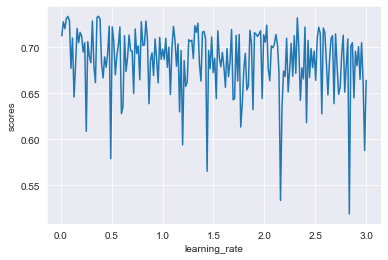

In [7]:
scores = []
learning_rates = []
for i in np.linspace(0.01, 3, 200):
    perceptron = PerceptronDescent(learning_rate=i, epochs = 1000)
    perceptron.fit(X_train, y_train.values)
    score = perceptron.score(X_test, y_test.values)
    scores.append(score)
    learning_rates.append(i)


score_df = pd.DataFrame({
    'learning_rate':learning_rates, 
    'scores':scores
})


sns.lineplot(x = 'learning_rate', y = 'scores', data = score_df)
plt.show()

In [8]:
perceptron = PerceptronDescent(learning_rate=0.05, epochs = 1000)
perceptron.fit(X_train, y_train.values)
perceptron.score(X_test, y_test.values)

0.7312146512254242

In [9]:
y_test.values.shape

(11139,)

In [69]:
class MBLogisticDescent(BaseEstimator, TransformerMixin):

    def __init__(self, learning_rate = 0.001, epochs = 1000, batch_size = 30, threshold = 0.5):
        self.__name = 'mini-batch-logistic-descent'
        self.learning_rate = learning_rate 
        self.epochs = epochs 
        self.batch_size = batch_size 
        self.threshold = threshold 

    def sigmoid(self, z):
        return 1/(1+np.exp(-z))

    def fit(self, X, y):
        rows, cols = X.shape 
        y = y.reshape(-1, 1)
        self.W = np.zeros((cols+1, 1))
        beta = np.ones((rows, 1))

        X_ = np.hstack(
            (beta, X) 
        )

        for i in range(self.epochs):
            indices = np.random.randint(0, rows, 30)
            sigma_z = self.sigmoid(X_[indices].dot(self.W)) 
             
            slope = X_[indices].T.dot(
                y[indices]*(1 - sigma_z) - ( 1 - y[indices])*(sigma_z)
            )

            self.W = self.W + self.learning_rate*slope 

        return self 
    
    def predict(self, X):
        rows, cols = X.shape
        beta = np.ones((rows, 1))

        X_ = np.hstack(
            (beta, X)
        )

        self.probabilities = self.sigmoid(X_.dot(self.W)) 
        predicted = np.array([1 if probability > self.threshold else 0 for probability in self.probabilities]) 
        return predicted 
    
    def score(self, X, y):
        predictions = self.predict(X)
        return accuracy_score(y, predictions)
        


descent = MBLogisticDescent(learning_rate=0.01, epochs=100, batch_size=10)
descent.fit(X_train, y_train.values)
descent.score(X_test, y_test)

0.7378579764790376

In [52]:
map = PCA(n_components=2)
features = map.fit_transform(X_train)
df = pd.DataFrame(
    np.hstack(
        (features, descent.probabilities, descent.predict(X_train).reshape(-1, 1))
    ), 
    columns = ['f1', 'f2', 'probability', 'predictions']
)

In [56]:
df['actual'] = y_train
px.scatter_3d(data_frame=df, x = 'f1', y = 'f2', z = 'probability', color = 'actual')

In [61]:
y_train.shape

(44553,)